### Explanation about example:

Data
- data are referred to Ratio Table statements of Financial services companies

Pipeline:
1. from scratch we will check data to impute
2. by threshold we will remove columns that are over them
3. will encoding category and time series columns
4. test three different models of data imputation (Miceforest, BayesianRidge, LinearRegression)
5. check perfomance of each model (just look that model's performance change over each running, so also the check is done seeing if values imputed have sense to the other ones)
6. use model best performed 

<!--  -->

------------

In [1]:
# Set up
import pandas as pd
import numpy as np
from IPython.display import display

<!--  -->

### Connect to dataframe

About the dataframe rt_y (ratio table year):
- it's available to anyone (just run the cell to get it)
- It's about Ratio Table statements. Especially, it collects all listed European companies about "Financial Services" sector which start by "A" and "B" letters

In [34]:
# Get data from df shared
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
link_file_1 = '1wJCcu0u1PU41sNSHugC28nm9npDmDRT9' # file code Ratio table
link_file_2 = '1zWzIP_58rx2c5kys3WkWhG4jHW4tDctu' # file code countries grouping

# Read files using the function
rt_y = read_gdrive_to_df(link_file_1)
aggregated_countries = read_gdrive_to_df(link_file_2)

In [35]:
# Check data type
rt_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, 448 to 684
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sector                 808 non-null    object 
 1   Super Sector           808 non-null    object 
 2   industry_name          808 non-null    object 
 3   Country                808 non-null    object 
 4   Exchange               808 non-null    object 
 5   Ticker                 808 non-null    object 
 6   Company Name           808 non-null    object 
 7   Currency Sign          808 non-null    object 
 8   Year                   808 non-null    int64  
 9   Liabilities to Assets  799 non-null    float64
 10  Debt to Liabilities    796 non-null    float64
 11  Debt to EquityRatio    801 non-null    float64
 12  ReturnOnEquity         802 non-null    float64
 13  Capex to EBIT          802 non-null    float64
 14  D & A aprox to EBITDA  798 non-null    float64
 15  Operating

In [36]:
# -- 'category' type will help up in future models
def convert_to_category(df, last_col='Year'):
    """
    Convert columns of a DataFrame from the beginning up to the specified column (inclusive) to 'category' data type.

    Parameters:
    - df: DataFrame to be modified
    - last_col: The last column in the sequence of columns to be converted. Default is 'Year'

    Returns:
    - Modified DataFrame with specified columns converted to 'category'
    """
    
    # Get the list of columns
    cols = df.columns.tolist()

    # Find the index of the specified column
    index = cols.index(last_col)

    # Select columns from start to specified column (included)
    cols_to_convert = cols[:index+1]

    # Convert these columns to 'category' type
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    
    return df

rt_y = convert_to_category(rt_y, last_col='Year')

In [37]:
# Convert object columns and 'Year' col to 'category' type
rt_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, 448 to 684
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Sector                 808 non-null    category
 1   Super Sector           808 non-null    category
 2   industry_name          808 non-null    category
 3   Country                808 non-null    category
 4   Exchange               808 non-null    category
 5   Ticker                 808 non-null    category
 6   Company Name           808 non-null    category
 7   Currency Sign          808 non-null    category
 8   Year                   808 non-null    category
 9   Liabilities to Assets  799 non-null    float64 
 10  Debt to Liabilities    796 non-null    float64 
 11  Debt to EquityRatio    801 non-null    float64 
 12  ReturnOnEquity         802 non-null    float64 
 13  Capex to EBIT          802 non-null    float64 
 14  D & A aprox to EBITDA  798 non-null    float6

In [38]:
# Check data type
aggregated_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TotPtsQle  17 non-null     int64 
 1   Number     17 non-null     int64 
 2   Countries  17 non-null     object
dtypes: int64(2), object(1)
memory usage: 544.0+ bytes


<!--  -->

## Predictions

Steps:
- NaN values dataframe check potentially columns to remove (based on custom threshold)
- Define columns to keep
- Skewness
- Encoding
- Test imputation models
- Impute nan values using selected method

<!--  -->

**<u>NaN values dataframe</u>**
check potentially columns to remove (based on you threshold defined)

In [39]:
rt_y.isna().sum()/len(rt_y)

Sector                   0.000000
Super Sector             0.000000
industry_name            0.000000
Country                  0.000000
Exchange                 0.000000
Ticker                   0.000000
Company Name             0.000000
Currency Sign            0.000000
Year                     0.000000
Liabilities to Assets    0.011139
Debt to Liabilities      0.014851
Debt to EquityRatio      0.008663
ReturnOnEquity           0.007426
Capex to EBIT            0.007426
D & A aprox to EBITDA    0.012376
OperatingMargin          0.417079
dtype: float64

In [40]:
# Drop columns whitin nan are more than 30%
rt_y1 = rt_y.drop('OperatingMargin', axis=1)

<!--  -->

**<u>Define columns to keep**

In [58]:
# To ckeck which column let us make one hot base on columns number that contains enough values
rt_y['industry_name'].value_counts() # check values inside the column

industry_name
Investing/Securities    407
Banking/Credit          317
Insurance                84
Name: count, dtype: int64

In [59]:
def filter_columns(df, keep_columns, start_column):
    # Create a list of columns to keep based on the specified start point
    columns_from_start = df.columns[df.columns.get_loc(start_column):].tolist()
    
    # We merge the two column lists
    final_columns = keep_columns + columns_from_start
    
    # Filter the DataFrame to keep only the desired columns
    return df[final_columns]

In [60]:
# Columns to keep are 'industry_name', 'Country' and all columna after 'Year' (included)
rt_y1 = filter_columns(rt_y1, ['industry_name', 'Country'], 'Year')
rt_y1 = rt_y1.sort_values(by='Year', ascending=True)

<!--  -->

**<u>Skewness</u>**
*Check data distribution*

In [72]:
# pip install scipy --upgrade

In [73]:
import klib
import seaborn as sns

In [74]:
# Check columns category to select for not pass in skewness check
rt_y.columns

Index(['Sector', 'Super Sector', 'industry_name', 'Country', 'Exchange',
       'Ticker', 'Company Name', 'Currency Sign', 'Year',
       'Liabilities to Assets', 'Debt to Liabilities', 'Debt to EquityRatio',
       'ReturnOnEquity', 'Capex to EBIT', 'D & A aprox to EBITDA',
       'OperatingMargin'],
      dtype='object')

In [75]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def skewness_dataframe(df, exclude_columns=[]):
    df_copy = df.copy()
    selected_columns = df.select_dtypes(include=[np.number]).columns.tolist()  # Otteniamo una lista di colonne numeriche
    
    # Rimuovi le colonne da escludere dalla lista delle colonne selezionate
    for exc_col in exclude_columns:
        if exc_col in selected_columns:
            selected_columns.remove(exc_col)
            
    for col in selected_columns:
        klib.dist_plot(df_copy[col])

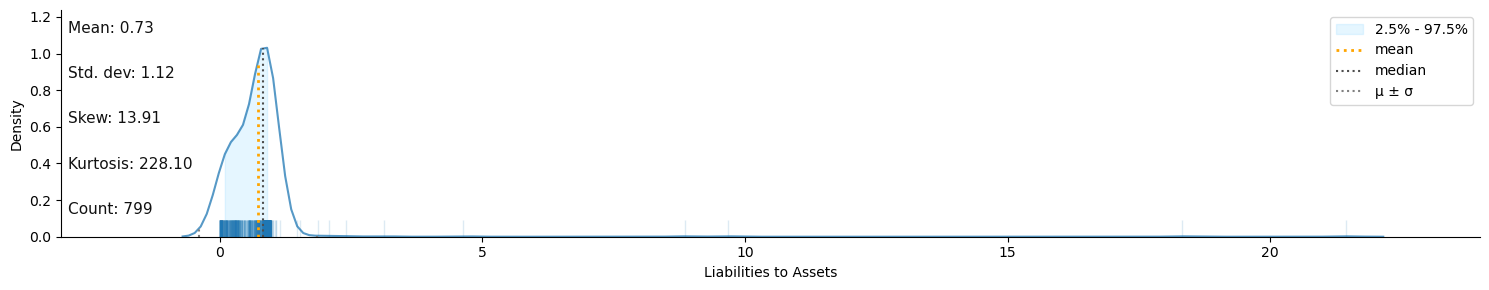

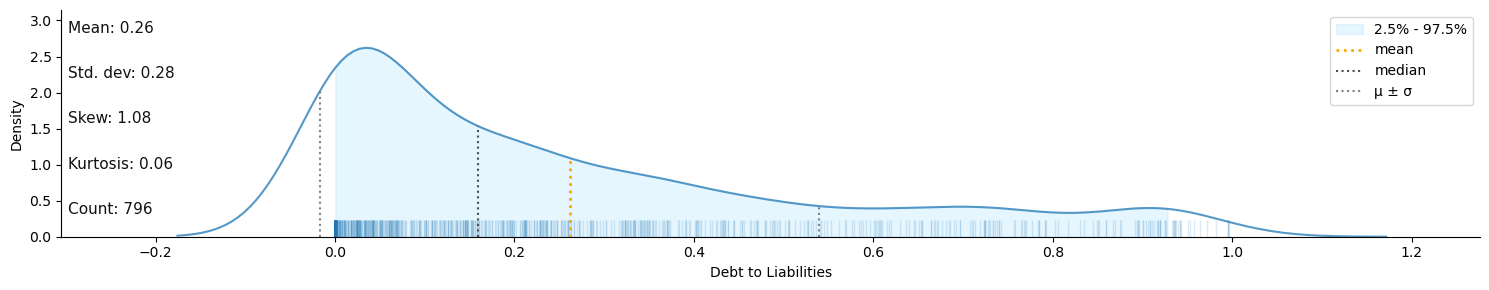

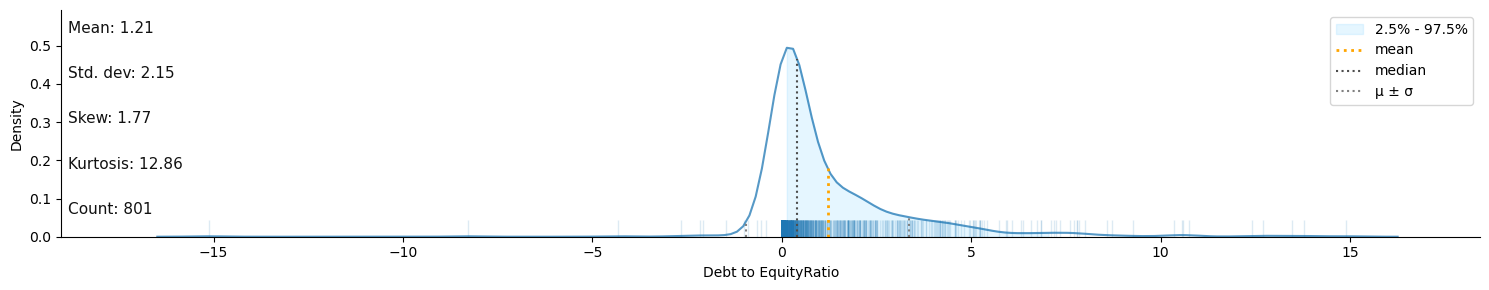

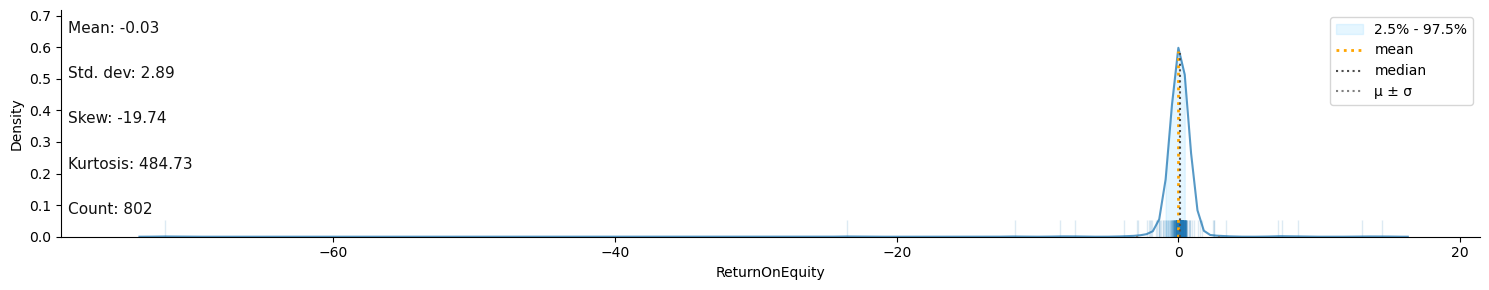

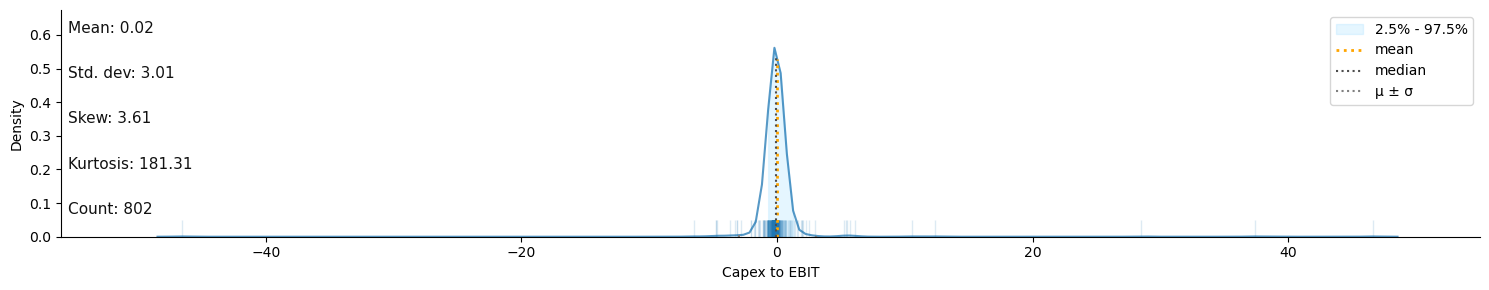

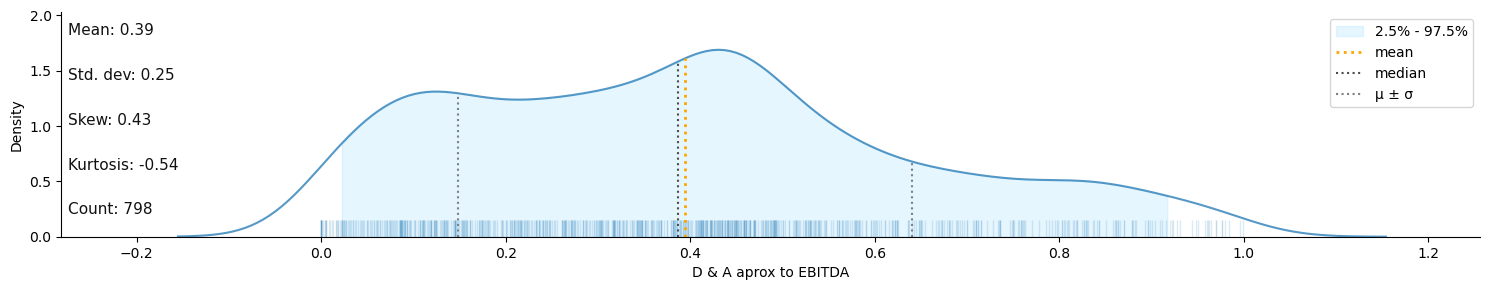

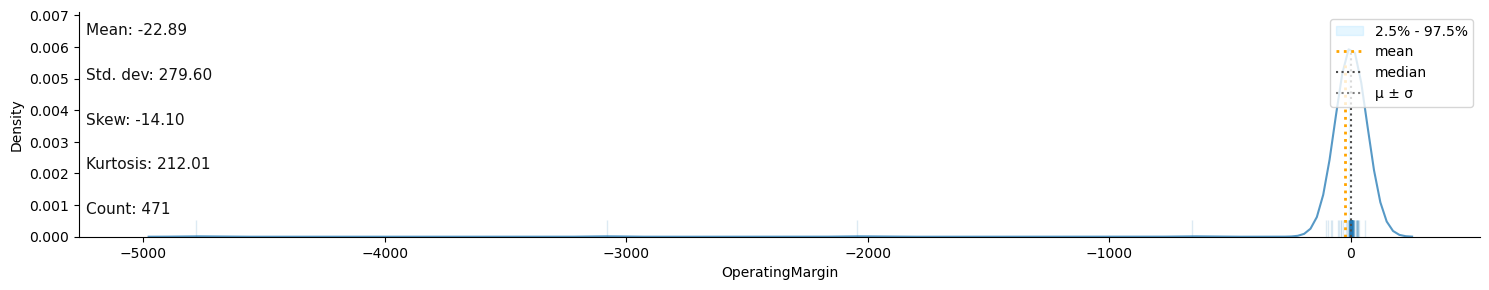

In [77]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

skewness_dataframe(rt_y)

<!--  -->

**<u>Encoding</u>**
- industry: one hot
- country: label encodig (test because it can influence the predictions)
- year: ordinal encoding

In [78]:
aggregated_countries.sort_values(by='TotPtsQle', ascending=False)

,TotPtsQle,Number,Countries
16,23,1,Germany
15,20,1,Belgium
14,18,1,Netherlands
13,17,1,Denmark
12,16,2,"Greece, Switzerland"
11,15,4,"Austria, Czechia, Italy, Poland"
10,14,2,"Luxembourg, Portugal"
9,13,2,"Cyprus, Sweden"
8,12,3,"Norway, Romania, Spain"
7,11,2,"France, Hungary"


In [79]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 1. One Hot Encoding per 'industry_name'
rt_y1 = pd.concat([rt_y1, pd.get_dummies(rt_y1['industry_name'], prefix='industry_name')], axis=1)
rt_y1.drop('industry_name', axis=1, inplace=True)

# List one hot cols
one_hot_columns = [col for col in rt_y1.columns if "industry_name_" in col]

# Replace true and false with 0 and 1
for col in one_hot_columns:
    rt_y1[col] = rt_y1[col].astype(int)

In [80]:
# Countries: inizialize disct to map
country_mapping = {}

# Populating of the mapping dictionary
for index, row in aggregated_countries.iterrows():
    countries = row['Countries'].split(", ")
    for country in countries:
        country_mapping[country] = row['TotPtsQle']

# Map values in the rt_y1 'Country' column using the dictionary
rt_y1['Country'] = rt_y1['Country'].map(country_mapping)

In [81]:
# 3. Ordinal Encoding per 'Year'
# If they are not, you can specify the order with the 'categories' parameter of the OrdinalEncoder
oe = OrdinalEncoder(categories=[sorted(rt_y1['Year'].unique())])
rt_y1['Year'] = oe.fit_transform(rt_y1[['Year']]).astype(int)

# --- Order columns (one hot col first)
# List cols one hot
one_hot_columns = [col for col in rt_y1.columns if "industry_name_" in col]

# Column order: first one-hot columns, then the others
new_column_order = one_hot_columns + [col for col in rt_y1.columns if col not in one_hot_columns]

# Rearrange the DataFrame columns in the new order
rt_y1 = rt_y1[new_column_order]

In [82]:
# Check df encoded
rt_y1.head(5)

,industry_name_Banking/Credit,industry_name_Insurance,industry_name_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to EquityRatio,ReturnOnEquity,Capex to EBIT,D & A aprox to EBITDA
448,0,0,1,11,0,0.044072,0.347287,0.016011,0.131094,0.000000,0.093327
436,0,0,1,8,0,0.016397,0.000000,0.000000,-0.146714,0.000000,0.858621
650,0,0,1,18,0,0.365789,0.404317,0.234167,-0.765833,0.033843,0.171041
392,0,1,0,10,0,0.709727,0.061324,0.148501,0.261842,-0.094505,0.224828
264,1,0,0,12,0,0.838983,0.027239,0.142522,0.072653,-0.194834,0.439768


**<u>Test imputation models</u>**
(Data imputation has been tested using repository created and available in GitHub)

<!--  -->

Test MICE model

In [ ]:
# Install libraries need
# pip install miceforest
# pip install miceforest --upgrade
# pip install git+https://github.com/AnotherSamWilson/miceforest.git # (if miceforest previous install does not work)
# pip install dask --upgrade
# pip install lightgbm --upgrade

In [86]:
# Miceforest (MICE)
import miceforest as mf
from miceforest import ImputationKernel
from sklearn.metrics import mean_squared_error

In [87]:
# test one: made by all data

def mice_imputation_test(df, col_to_test = 'HICP(%)', cols_to_category=['geo', 'country', 'year']):
    
    
    '''
    --> test one: made using all data for imputation
     
    =================
    
    Impute need:
    
    Select original dataframe (with nan values)
    
    1) Select df with original values
    1) Select columns to test. That values will be randomly converted to nan and tested with predictions
    2) All nan values predicted will be compared with real
    
    Note: Make sure you don't have empty values in category columns selected
    
    =================
    
    Output:
    
    - kds: imputed data
    - imputed_df: dataframe imputed
    - comparison_df: dataframe with true values and imputed values
    - rmse: Root Mean Squared Error (RMSE) is calculated between the real and imputed values.
    
    '''
    
    global imputed_df, comparison_df, percentage_error_mice, rmse_mice, kds
    
    # If columns are not category yet, convert them
    df_mf = df.copy()
    df_mf[cols_to_category] = df_mf[cols_to_category].astype('category')
    
    # Create a copy of the DataFrame and select a fraction of the known data to be imputed
    df_mf = df.dropna(subset=[col_to_test]).copy()
    true_values = df_mf.sample(frac=0.1)[col_to_test]
    df_mf.loc[true_values.index, col_to_test] = np.nan
    
    # --- MICE model creating
    kds = mf.ImputationKernel(df_mf, random_state=42)
    
    # --- Tuning parameters
    optimal_parameters, losses = kds.tune_parameters(dataset=0, optimization_steps=20)
    kds.mice(1, variable_parameters=optimal_parameters)
    # print(optimal_parameters)
    # ---
    
    # --- Manual setting
    # n_estimators, are number of tree. So, define it considering how mauch data your df contains
    # kds.mice(iterations=20, n_estimators=10, device='gpu') # verbose=2

    # --- Complete the imputed data
    imputed_df = kds.complete_data()

    # Recovers the imputed values
    imputed_values = imputed_df.loc[true_values.index, col_to_test]

    # --- Calculate the RMSE
    rmse_mice = np.sqrt(mean_squared_error(true_values, imputed_values))

    # Calculate the percentage error
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_mice = (rmse_mice / range_of_data) * 100
    
    print(f'RMSE percentage_error (min,max): {percentage_error_mice:.2f}')
    print(f'RMSE: {rmse_mice:.2f}')

    # --- Create a DataFrame with real and imputed values
    comparison_df = pd.DataFrame({
        'True Values': true_values,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values]
    })
    
    display(comparison_df)

    return 

In [88]:
mice_imputation_test(rt_y1, col_to_test = 'ReturnOnEquity',
                 cols_to_category=['industry_name_Banking/Credit', 'industry_name_Insurance',
                                   'industry_name_Investing/Securities', 'Country', 'Year'])

RMSE percentage_error (min,max): 3.04
RMSE: 2.63


,True Values,Imputed Values
478,0.127273,0.12
170,0.112944,0.12
588,0.082560,0.12
125,0.035976,0.12
487,0.008161,0.48
...,...,...
648,0.151548,0.03
301,0.085065,0.13
715,-0.017193,0.18
585,0.282879,0.48


In [ ]:
# Plot to compare the distribution by data and data with imputation
# kds.plot_imputed_distributions(wspace=0.3,hspace=0.5)

<!--  -->

Test skelearn models

In [91]:
#- sklearn imputation libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [99]:
def iterative_imputation_sklearn(df, estimator_choice='BayesianRidge', col_to_test = 'HICP(%)', grouping_col = 'geo'):
    
    '''
    Impute missing values using iterative imputer.
    
    Parameters:
    - df: DataFrame
    - estimator_choice: Either 'BayesianRidge' or 'LinearRegression'
    
    Returns:
    imputed_df, comparison_df, rmse
    '''
    
    global imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn
    
    # Check estimator choice
    if estimator_choice not in ['BayesianRidge', 'LinearRegression']:
        raise ValueError("estimator_choice must be either 'BayesianRidge' or 'LinearRegression'")

    # Select column to check
    
    true_values_list = []
    imputed_values_list = []
    categorical_values_list = []

    # If grouping_col is specified, group by that column, otherwise use the entire dataframe as a single group.
    if grouping_col:
        groups = df.groupby(grouping_col)
    else:
        groups = [df] # Wrap the dataframe in a list to make it compatible with the rest of the code
    
    # Model used
    print('BayesianRidge model')

    # Define a function to impute missing values within each group
    def impute_group(group):
        subset_group = group.dropna(subset=[col_to_test]).copy()
        true_values = subset_group.sample(frac=0.1)[col_to_test]
        subset_group.loc[true_values.index, col_to_test] = np.nan
        numerical_columns = subset_group.select_dtypes(include=[np.number]).columns
        
        # -- model decided to use in udf setting
        if estimator_choice == 'BayesianRidge':
            imp = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=0)
        else:
            imp = IterativeImputer(estimator=LinearRegression(), max_iter=30, random_state=0)
            
        subset_group[numerical_columns] = imp.fit_transform(subset_group[numerical_columns])
        
        categorical_columns = subset_group.select_dtypes(exclude=[np.number]).columns
        # --
        
        for idx in true_values.index:
            true_values_list.append(true_values[idx])
            imputed_values_list.append(subset_group.loc[idx, col_to_test])
            categorical_values_list.append(group.loc[idx, categorical_columns])

        return subset_group

    # Apply the imputation function
    if grouping_col:
        imputed_df = groups.apply(impute_group).reset_index(drop=True)
    else:
        imputed_df = impute_group(df)
    
    # -- df comparing values
    comparison_df = pd.DataFrame({
        **pd.DataFrame(categorical_values_list),
        'True Values': true_values_list,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values_list]
    })
    
    # -- Evaluate model
    rmse_sklearn = np.sqrt(mean_squared_error(true_values_list, imputed_values_list))
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_sklearn = (rmse_sklearn / range_of_data) * 100
    
    print(f'MEAN true values: {np.mean(true_values_list):.2f}')
    print(f'MEAN imputed values: {np.mean(imputed_values_list):.2f}')
    print(f'RMSE percentage_error (min,max): {percentage_error_sklearn:.2f}')
    print(f'RMSE: {rmse_sklearn:.2f}')
    
    display(comparison_df.head())

    return

In [93]:
# BayesianRidge
iterative_imputation_sklearn(rt_y1, estimator_choice='BayesianRidge', col_to_test = 'ReturnOnEquity', grouping_col = None)

BayesianRidge model
MEAN true values: -0.09
MEAN imputed values: -0.03
RMSE percentage_error (min,max): 1.23
RMSE: 1.06


,True Values,Imputed Values
0,0.127505,0.05
1,0.043299,0.10
2,0.119394,-0.00
3,0.635086,0.04
4,0.178377,0.06


In [94]:
# Name variable
percentage_error_sklearn_Bayesian = percentage_error_sklearn
rmse_sklearn_Bayesian = rmse_sklearn

<!--  -->

In [100]:
# IMPORTANT: before running it rerun the udf above 'iterative_imputation_sklearn'
# LinearRegression
iterative_imputation_sklearn(rt_y1, estimator_choice='LinearRegression', col_to_test = 'ReturnOnEquity', grouping_col = None)

BayesianRidge model
MEAN true values: -0.10
MEAN imputed values: 0.07
RMSE percentage_error (min,max): 1.62
RMSE: 1.40


,True Values,Imputed Values
0,-11.624490,-0.39
1,0.234083,-0.28
2,0.216595,-0.22
3,0.020729,-0.05
4,0.001707,-0.21


In [103]:
# Name variable
percentage_error_sklearn_Linear = percentage_error_sklearn
rmse_sklearn_Linear = rmse_sklearn

In [104]:
# Print models RMSE percentage_error (min,max) and RMSE
# (RMSE perc. and RMSE could be high, but reason is that low values are imputed compared to real one existed)

print('Percentage of Missing values:\n')
for col in rt_y1.columns:
    missing_percentage = (rt_y1[col].isna().sum() / len(rt_y1) * 100)
    print(f'{col}: {missing_percentage:.2f}%')
print('\n')

print('All imputation model tested results\n')
print('MICE')
print(f'RMSE percentage_error (min,max): {percentage_error_mice:.2f}')
print(f'RMSE: {rmse_mice:.2f}')
print('='*15)

print('BayesianRidge')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Bayesian:.2f}")
print(f'RMSE: {rmse_sklearn_Bayesian:.2f}')
print('='*15)

print('LinearRegression')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Linear:.2f}")
print(f'RMSE: {rmse_sklearn_Linear:.2f}')

print('\nNOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.')

Percentage of Missing values:

industry_name_Banking/Credit: 0.00%
industry_name_Insurance: 0.00%
industry_name_Investing/Securities: 0.00%
Country: 0.00%
Year: 0.00%
Liabilities to Assets: 1.11%
Debt to Liabilities: 1.49%
Debt to EquityRatio: 0.87%
ReturnOnEquity: 0.74%
Capex to EBIT: 0.74%
D & A aprox to EBITDA: 1.24%


All imputation model tested results

MICE
RMSE percentage_error (min,max): 3.04
RMSE: 2.63
BayesianRidge
RMSE percentage_error (min,max): 1.23
RMSE: 1.06
LinearRegression
RMSE percentage_error (min,max): 1.62
RMSE: 1.40

NOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.


<!--  -->

**Impute nan values using selected method**

In [114]:
rt_y1_imputed = rt_y1.copy()

In [115]:
# Before imputation
rt_y1_imputed.isna().sum().sum()

50

In [126]:
# Model definition to imputing nan values
def iterative_imputation_sklearn_all_df(df, estimator_choice='BayesianRidge', col_to_test = 'HICP(%)', grouping_col = 'geo', highlight_imputed=False):
    
    global imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn, imputed_coordinates, coordinates_df, imputed_values_list, styles # true_values_list
    
    if estimator_choice not in ['BayesianRidge', 'LinearRegression']:
        raise ValueError("estimator_choice must be either 'BayesianRidge' or 'LinearRegression'")

    true_values_list = []
    imputed_values_list = []
    categorical_values_list = []

    if grouping_col:
        groups = df.groupby(grouping_col)
    else:
        groups = [df] # Wrap the dataframe in a list to make it compatible with the rest of the code
    
    print(f'Model used: {estimator_choice}\n')
    
    # Initialize the list and collect NaN coordinates
    imputed_coordinates = []
    for col in df.columns:
        if df[col].isna().any():
            for index in df[df[col].isna()].index:
                imputed_coordinates.append((col, index))
    
    # Create an empty dictionary to store coordinates
    coordinates_dict = {}

    for col, index in imputed_coordinates:
        if col not in coordinates_dict:
            coordinates_dict[col] = []
        coordinates_dict[col].append(index)

    # Convert dictionary to a DataFrame
    coordinates_df = pd.DataFrame.from_dict(coordinates_dict, orient='index').transpose()

    # Fill in the Missing Values with 9.99 caused by mismatched length values imputed on columns
    coordinates_df.fillna(9.99, inplace=True)

    def impute_group(group):
        subset_group = group.dropna(subset=[col_to_test]).copy()
    
        if subset_group.empty:
            return group

        true_values = subset_group.sample(frac=0.1)[col_to_test]
        true_values_list.extend(true_values)
        
        numerical_columns = group.select_dtypes(include=[np.number]).columns
        
        if estimator_choice == 'BayesianRidge':
            imp = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=0)
        else:
            imp = IterativeImputer(estimator=LinearRegression(), max_iter=30, random_state=0)
        
        group[numerical_columns] = imp.fit_transform(group[numerical_columns])
                
        imputed_values_for_true = group.loc[true_values.index, col_to_test]
        imputed_values_list.extend(imputed_values_for_true)

        return group

    # Apply the imputation function
    if grouping_col:
        imputed_df = groups.apply(impute_group).reset_index(drop=True)
    else:
        imputed_df = impute_group(df)
    
    # -- df comparing values
    comparison_df = pd.DataFrame({
        **pd.DataFrame(categorical_values_list),
#         'True Values': true_values_list,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values_list]
    })
    
    # -- Evaluate model
    if not true_values_list or not imputed_values_list:
        print("One or both lists are empty!")
        return
    
    rmse_sklearn = np.sqrt(mean_squared_error(true_values_list, imputed_values_list))
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_sklearn = (rmse_sklearn / range_of_data) * 100
    
    print('To print dataframe with index imputed variable is: "coordinates_df" (values 9.99 are just to make df equal rows)')
    
    display(comparison_df)
    
    if highlight_imputed:
        def highlight_cells(data):
            # Create a default 'no highlight' style for all cells
            styles = pd.DataFrame('', index=data.index, columns=data.columns)

            # For each coordinate in the imputed_coordinates, set the background color
            for col, row in imputed_coordinates:
                styles.at[row, col] = 'background-color: yellow'
            return styles
        
        display(imputed_df.style.apply(highlight_cells, axis=None))

    return

In [127]:
# Following will see the data imputed and all the dataframe with imputed data highlighted

In [128]:
# BayesianRidge 
iterative_imputation_sklearn_all_df(rt_y1_imputed, estimator_choice='BayesianRidge', col_to_test = 'ReturnOnEquity', grouping_col = None, highlight_imputed=True)

Model used: BayesianRidge

To print dataframe with index imputed variable is: "coordinates_df" (values 9.99 are just to make df equal rows)


,Imputed Values
0,0.10
1,0.08
2,0.06
3,0.02
4,0.44
...,...
75,0.13
76,0.16
77,-0.28
78,0.08


,industry_name_Banking/Credit,industry_name_Insurance,industry_name_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to EquityRatio,ReturnOnEquity,Capex to EBIT,D & A aprox to EBITDA
448,0.000000,0.000000,1.000000,11.000000,0.000000,0.044072,0.347287,0.016011,0.131094,0.000000,0.093327
436,0.000000,0.000000,1.000000,8.000000,0.000000,0.016397,0.000000,0.000000,-0.146714,0.000000,0.858621
650,0.000000,0.000000,1.000000,18.000000,0.000000,0.365789,0.404317,0.234167,-0.765833,0.033843,0.171041
392,0.000000,1.000000,0.000000,10.000000,0.000000,0.709727,0.061324,0.148501,0.261842,-0.094505,0.224828
264,1.000000,0.000000,0.000000,12.000000,0.000000,0.838983,0.027239,0.142522,0.072653,-0.194834,0.439768
713,0.000000,0.000000,1.000000,10.000000,0.000000,0.851852,0.332193,1.903242,0.015647,-0.271277,0.530000
745,0.000000,0.000000,1.000000,13.000000,0.000000,0.051208,0.000000,0.000000,-0.275064,0.000000,0.158025
793,0.000000,0.000000,1.000000,15.000000,0.000000,0.029649,0.000000,0.000000,0.139317,0.000000,0.590264
757,0.000000,0.000000,1.000000,20.000000,0.000000,0.017504,0.000000,0.000000,0.084909,0.000000,0.457955
184,1.000000,0.000000,0.000000,17.000000,0.000000,0.853723,0.025040,0.144829,0.068658,0.000000,0.077346


In [129]:
# Dataframe explained for each column index where nan has been replaces
coordinates_df.sort_values(by=['Liabilities to Assets'], ascending=True)

,Liabilities to Assets,Debt to Liabilities,Debt to EquityRatio,ReturnOnEquity,Capex to EBIT,D & A aprox to EBITDA
9,9.99,872.0,9.99,9.99,9.99,127.00
10,9.99,127.0,9.99,9.99,9.99,9.99
11,9.99,474.0,9.99,9.99,9.99,9.99
3,126.00,666.0,655.00,655.00,518.00,666.00
7,127.00,704.0,9.99,9.99,9.99,656.00
1,384.00,598.0,666.00,666.00,666.00,384.00
8,474.00,656.0,9.99,9.99,9.99,872.00
0,598.00,717.0,384.00,384.00,384.00,869.00
4,655.00,541.0,656.00,656.00,656.00,870.00
6,656.00,655.0,127.00,9.99,9.99,126.00


In [130]:
# Sum tot nan after imputation
rt_y1_imputed.isna().sum().sum()

0

In [131]:
rt_y1_imputed

,industry_name_Banking/Credit,industry_name_Insurance,industry_name_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to EquityRatio,ReturnOnEquity,Capex to EBIT,D & A aprox to EBITDA
448,0.0,0.0,1.0,11.0,0.0,0.044072,0.347287,0.016011,0.131094,0.000000,0.093327
436,0.0,0.0,1.0,8.0,0.0,0.016397,0.000000,0.000000,-0.146714,0.000000,0.858621
650,0.0,0.0,1.0,18.0,0.0,0.365789,0.404317,0.234167,-0.765833,0.033843,0.171041
392,0.0,1.0,0.0,10.0,0.0,0.709727,0.061324,0.148501,0.261842,-0.094505,0.224828
264,1.0,0.0,0.0,12.0,0.0,0.838983,0.027239,0.142522,0.072653,-0.194834,0.439768
...,...,...,...,...,...,...,...,...,...,...,...
605,0.0,0.0,1.0,13.0,3.0,0.211096,0.875939,0.235138,0.047232,0.000000,0.008451
379,0.0,1.0,0.0,11.0,3.0,0.931061,0.004001,0.054036,0.135650,-0.561873,0.524642
315,1.0,0.0,0.0,11.0,3.0,0.946629,0.050165,0.891993,0.114391,-0.047601,0.224024
502,0.0,0.0,1.0,12.0,3.0,0.278609,0.213251,0.082360,0.134091,-0.046206,0.069496
